In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os,sys
opj = os.path.join
from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

from ex_mnist import p
from dset import get_dataloader, load_pretrained_model

# adaptive-wavelets modules
from losses import get_loss_f
from train import Trainer
from evaluate import Validator
from transform2d import DWT2d
from utils import get_2dfilts, get_wavefun
from wave_attributions import Attributer
from visualize import cshow, plot_1dfilts, plot_2dfilts, plot_2dreconstruct, plot_wavefun

# evaluation
from matplotlib import gridspec

In [2]:
# load data and model
train_loader, test_loader = get_dataloader(p.data_path,
                                           batch_size=p.batch_size)

model = load_pretrained_model(p.model_path)[0]

# load wavelet
wt = DWT2d(wave='db3', mode='periodization', J=3, init_factor=1, noise_factor=0.0).to(device)
wt.load_state_dict(torch.load('results/wt.pth'))

<All keys matched successfully>

In [3]:
class Wave_CNN(nn.Module):
    def __init__(self, wt):
        super(Wave_CNN, self).__init__()
        self.fc1 = nn.Linear(889, 50)
        self.fc2 = nn.Linear(50, 10)
        self.wt = wt.eval()
        self.wt.J = 3
        # freeze layers
        for param in wt.parameters():
            param.requires_grad = False           

    def forward(self, x):
        batch_size = x.shape[0]
        x_t = self.wt(x)
        
        x_t0 = x_t[0]
        x_t1 = x_t[1]
        x_t2 = x_t[2]
        x_t3 = x_t[3]
        
        self.wt.J = 2
        x_t1 = self.wt(F.relu(x_t1.squeeze()))
        self.wt.J = 1
        x_t2 = self.wt(F.relu(x_t2.squeeze()))
        
        x = []
        x.append(x_t0.reshape(batch_size,-1))
        for j in range(len(x_t1)):
            x.append(x_t1[j].reshape(batch_size,-1))
        for j in range(len(x_t2)):
            x.append(x_t2[j].reshape(batch_size,-1))            
        x.append(x_t3.reshape(batch_size,-1))
        x = torch.cat(x,1)
        
        x = F.relu(self.fc1(x))
        x = self.fc2(x) 
        
        self.wt.J = 3
        return x

In [4]:
wcnn = Wave_CNN(wt).to(device)
optimizer = torch.optim.Adam(wcnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 50

train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device)
        y = y.to(device)
        # zero grad
        optimizer.zero_grad()
        output = wcnn(data)
        loss = criterion(output, y)
        
        # backward
        loss.backward()
        # update step
        optimizer.step()          
        
        iter_loss = loss.item()   
        epoch_loss += iter_loss

        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), iter_loss), end='')              

    mean_epoch_loss = epoch_loss / (batch_idx + 1)
    train_losses.append(mean_epoch_loss)

# save model
# torch.save(cnn.state_dict(), opj(p.model_path, 'CNN.pth')) 
    

Train Epoch: 49 [19900/20000 (100%)]	Loss: 0.000177

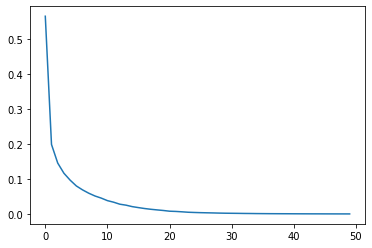

In [5]:
plt.plot(train_losses)

In [6]:
# check prediction
m = len(test_loader.dataset)
batch_size = test_loader.batch_size

y_pred_cnn = np.zeros(m)
y_pred_wcnn = np.zeros(m)
y_true = np.zeros(m)
with torch.no_grad():
    for batch_idx, (data, y) in tqdm(enumerate(test_loader, 0), total=int(np.ceil(m / batch_size))):
        data = data.to(device)
        # cnn prediction
        outputs_cnn = model(data)
        _, y_pred = torch.max(outputs_cnn.data, 1)
        y_pred_cnn[batch_idx*batch_size:(batch_idx+1)*batch_size] = y_pred.cpu().numpy()
        
        # ffn prediction
        outputs_ffn = wcnn(data)
        _, y_pred = torch.max(outputs_ffn.data, 1)
        y_pred_wcnn[batch_idx*batch_size:(batch_idx+1)*batch_size] = y_pred.cpu().numpy() 
        
        # labels
        y_true[batch_idx*batch_size:(batch_idx+1)*batch_size] = y.numpy()
        
print("CNN accuracy {:.5f}% wCNN accuracy {:.5f}%".format((y_true == y_pred_cnn).sum()/m*100,
                                                       (y_true == y_pred_wcnn).sum()/m*100))

100%|██████████| 30/30 [00:01<00:00, 15.87it/s]

CNN accuracy 98.33333% wCNN accuracy 95.60000%


# Original wavelet

In [7]:
wt_o = DWT2d(wave='db3', mode='periodization', J=3, init_factor=1, noise_factor=0.0).to(device)
wcnn = Wave_CNN(wt_o).to(device)
optimizer = torch.optim.Adam(wcnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 50

train_losses = []

for epoch in range(num_epochs):
    epoch_loss = 0.
    for batch_idx, (data, y) in enumerate(train_loader):
        data = data.to(device)
        y = y.to(device)
        # zero grad
        optimizer.zero_grad()
        output = wcnn(data)
        loss = criterion(output, y)
        
        # backward
        loss.backward()
        # update step
        optimizer.step()          
        
        iter_loss = loss.item()   
        epoch_loss += iter_loss

        print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
                   100. * batch_idx / len(train_loader), iter_loss), end='')              

    mean_epoch_loss = epoch_loss / (batch_idx + 1)
    train_losses.append(mean_epoch_loss)

# save model
# torch.save(cnn.state_dict(), opj(p.model_path, 'CNN.pth')) 
    

Train Epoch: 49 [19900/20000 (100%)]	Loss: 0.000091

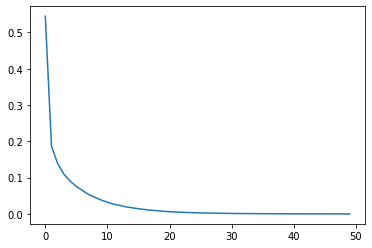

In [8]:
plt.plot(train_losses)

In [9]:
# check prediction
m = len(test_loader.dataset)
batch_size = test_loader.batch_size

y_pred_cnn = np.zeros(m)
y_pred_wcnn = np.zeros(m)
y_true = np.zeros(m)
with torch.no_grad():
    for batch_idx, (data, y) in tqdm(enumerate(test_loader, 0), total=int(np.ceil(m / batch_size))):
        data = data.to(device)
        # cnn prediction
        outputs_cnn = model(data)
        _, y_pred = torch.max(outputs_cnn.data, 1)
        y_pred_cnn[batch_idx*batch_size:(batch_idx+1)*batch_size] = y_pred.cpu().numpy()
        
        # ffn prediction
        outputs_ffn = wcnn(data)
        _, y_pred = torch.max(outputs_ffn.data, 1)
        y_pred_wcnn[batch_idx*batch_size:(batch_idx+1)*batch_size] = y_pred.cpu().numpy() 
        
        # labels
        y_true[batch_idx*batch_size:(batch_idx+1)*batch_size] = y.numpy()
        
print("CNN accuracy {:.5f}% wCNN accuracy {:.5f}%".format((y_true == y_pred_cnn).sum()/m*100,
                                                       (y_true == y_pred_wcnn).sum()/m*100))

100%|██████████| 30/30 [00:01<00:00, 17.43it/s]

CNN accuracy 98.33333% wCNN accuracy 95.40000%
